## Testing with param

Providing `model` parameters and name, running simulation to produce energy deposition vs. time plot.

In [2]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


In [3]:
def moving_average(a, n=3, zero_padding = False, const_padding = False):
    if n%2 != 1:
        raise ValueError(f"n must be an uneven number but is {n}")
    if zero_padding:
        ind = np.arange(n-1)
        a = np.insert(a, ind, np.zeros(n-1))
        a = np.roll(a, -int((n-1)/2))
    if const_padding:
        ind1 = np.arange((n-1)/2).astype(int)
        ind2 = -np.arange(1,(n-1)/2+1).astype(int)
        a = np.insert(a, ind1, np.ones(int((n-1)/2))*a[0])
        a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [183]:
dt = 0.5*u.ms # highest frequency in Tamborra 2014 model

model = {'name': 'Tamborra_2014',
         'param':{
             'progenitor_mass': 20*u.Msun}
         }
sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.006*u.s, tmax=0.338*u.s, dt=dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2')
sim.run()

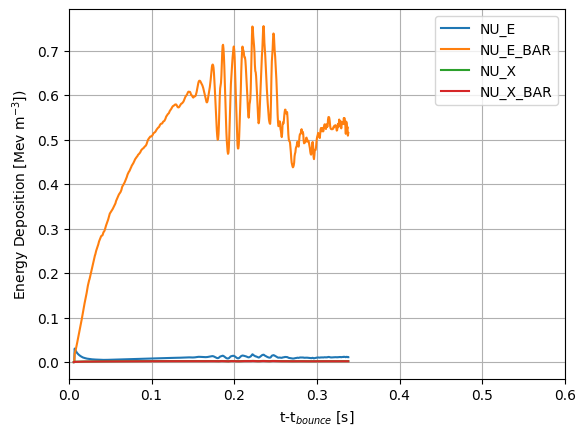

In [184]:
for flavor in sim.flavors:
    plt.plot(sim.time, sim.E_per_V[flavor], label=flavor.name)
plt.legend()
ax = plt.gca()
ax.set(xlabel=r't-t$_{bounce}$ [s]', ylabel='Energy Deposition [Mev m$^{-3}$])', xlim=(0, 0.6))
ax.grid()

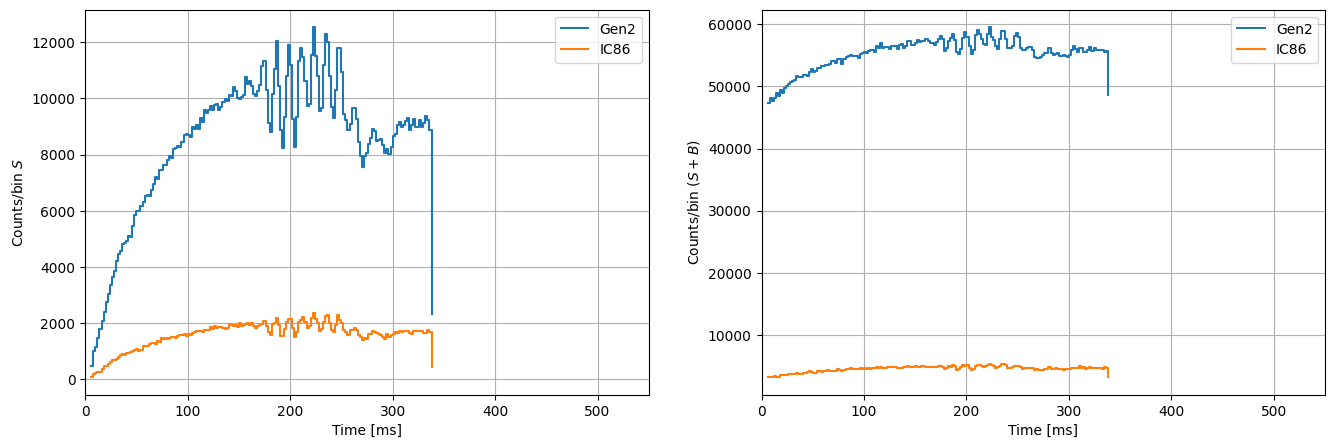

In [185]:
dt = 2*u.ms
bw = 25
sim.scale_result(distance=10*u.kpc)

t, i3_sig = sim.detector_hits(dt=dt, subdetector='i3')
t, dc_sig = sim.detector_hits(dt=dt, subdetector='dc')
t, md_sig = sim.detector_hits(dt=dt, subdetector='md')
t, comb_sig = sim.detector_hits(dt=dt)

t = t.to(u.ms)

i3_bkg = sim.detector.i3_bg(dt=dt, size=len(i3_sig))
dc_bkg = sim.detector.dc_bg(dt=dt, size=len(dc_sig))
md_bkg = sim.detector.md_bg(dt=dt, size=len(md_sig))
comb_bkg = i3_bkg + dc_bkg + md_bkg

i3 = i3_sig+i3_bkg
dc = dc_sig+dc_bkg
md = md_sig+md_bkg
comb = comb_sig+comb_bkg

sig_ic86 = i3_sig + dc_sig
sig_gen2 = comb_sig
bkg_ic86 = i3_bkg + dc_bkg
bkg_gen2 = comb_bkg

# moving average sig with bw binning size and constant padding
sig_avg_ic86 = moving_average(sig_ic86, n=bw, const_padding=True)
sig_avg_gen2 = moving_average(sig_gen2, n=bw, const_padding=True)

# average background rate given by the mean of the sensor distribution and scaled to the full detector
bkg_avg_ic86 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu)*dt/(1*u.s)
bkg_avg_gen2 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu + sim.detector.n_md*sim.detector.md_bg_mu)*dt/(1*u.s)


# combined signal + background counts
ic86 = sig_ic86 + bkg_ic86
gen2 = sig_gen2 + bkg_gen2

fig, ax = plt.subplots(1,2, figsize=(16,5))
for i in range(2):
    if i == 0:
        ax[i].step(t, sig_gen2, where='post', label='Gen2')
        ax[i].step(t, sig_ic86, where='post', label='IC86')
        ax[i].set_ylabel(r"Counts/bin $S$")

    elif i == 1:    
        ax[i].step(t, gen2, where='post', label='Gen2')
        ax[i].step(t, ic86, where='post', label='IC86')
        ax[i].set_ylabel(r"Counts/bin $(S+B)$")

    ax[i].set_xlabel("Time [ms]")
    ax[i].set_xlim(0,550)
    ax[i].legend()
    ax[i].grid()

In [186]:
dt = 1*u.ms
bw = 25

sample = 100000
sim.scale_result(distance=10*u.kpc)

mask = np.logical_and(t>=100*u.ms, t<=300*u.ms)
tf = t[mask]
N = len(tf)
T = sim._res_dt.value

Yf_gen2 = []
Yf_ic86 = []
Yfb_gen2 = []
Yfb_ic86 = []

for i in range(sample):
    i3_bkg = sim.detector.i3_bg(dt=dt, size=len(i3_sig))
    dc_bkg = sim.detector.dc_bg(dt=dt, size=len(dc_sig))
    md_bkg = sim.detector.md_bg(dt=dt, size=len(md_sig))
    comb_bkg = i3_bkg + dc_bkg + md_bkg

    sig_ic86 = i3_sig + dc_sig
    sig_gen2 = comb_sig
    bkg_ic86 = i3_bkg + dc_bkg
    bkg_gen2 = comb_bkg
    
    ic86 = sig_ic86 + bkg_ic86
    gen2 = sig_gen2 + bkg_gen2

    y_gen2 = gen2[mask]
    y_ic86 = ic86[mask]
    yb_gen2 = bkg_gen2[mask]
    yb_ic86 = bkg_ic86[mask]
     
    yf_gen2 = fft(y_gen2)
    yf_ic86 = fft(y_ic86)
    yfb_gen2 = fft(yb_gen2)
    yfb_ic86 = fft(yb_ic86)
    
    Yf_gen2.append(yf_gen2[1:N//2])
    Yf_ic86.append(yf_ic86[1:N//2])
    Yfb_gen2.append(yfb_gen2[1:N//2])
    Yfb_ic86.append(yfb_ic86[1:N//2])

xf = fftfreq(N,T)[1:N//2]
    
Yf_gen2 = np.array(Yf_gen2)
Yf_ic86 = np.array(Yf_ic86)
Yfb_gen2 = np.array(Yfb_gen2)
Yfb_ic86 = np.array(Yfb_ic86)

Yf_gen2 = np.mean(Yf_gen2, axis=0)
Yf_ic86 = np.mean(Yf_ic86, axis=0)
Yfb_gen2 = np.mean(Yfb_gen2, axis=0)
Yfb_ic86 = np.mean(Yfb_ic86, axis=0)

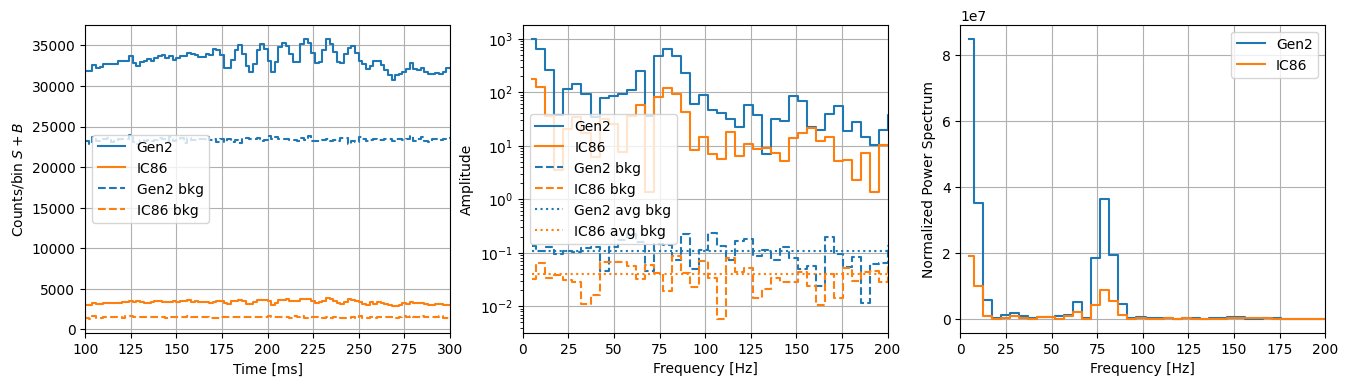

In [187]:
Yfb2_gen2 = np.ones_like(Yfb_gen2) * np.abs(Yfb_gen2).mean()
Yfb2_ic86 = np.ones_like(Yfb_ic86) * np.abs(Yfb_ic86).mean()


fig, ax = plt.subplots(1,3, figsize = (16,4))
ax[0].step(tf, y_gen2, label = 'Gen2')
ax[0].step(tf, y_ic86, label = 'IC86')
ax[0].step(tf, yb_gen2, label = 'Gen2 bkg', color = 'C0', ls = '--')
ax[0].step(tf, yb_ic86, label = 'IC86 bkg', color = 'C1', ls = '--')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel(r'Counts/bin $S+B$')
ax[0].set_xlim((tf[0].value,tf[-1].value))
ax[0].legend()
ax[0].grid()

ax[1].step(xf, 2.0/N * np.abs(Yf_gen2), where = 'mid', label = 'Gen2')
ax[1].step(xf, 2.0/N * np.abs(Yf_ic86), where = 'mid', label = 'IC86')
ax[1].step(xf, 2.0/N * np.abs(Yfb_gen2), where = 'mid', label = 'Gen2 bkg', color = 'C0', ls = '--')
ax[1].step(xf, 2.0/N * np.abs(Yfb_ic86), where = 'mid', label = 'IC86 bkg', color = 'C1', ls = '--')
ax[1].step(xf, 2.0/N * np.abs(Yfb2_gen2), where = 'mid', label = 'Gen2 avg bkg', color = 'C0', ls = ':')
ax[1].step(xf, 2.0/N * np.abs(Yfb2_ic86), where = 'mid', label = 'IC86 avg bkg', color = 'C1', ls = ':')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Amplitude')
ax[1].set_xlim((0,200))
ax[1].set_yscale('log')
ax[1].legend()
ax[1].grid()

ax[2].step(xf, np.abs(Yf_gen2)**2/np.abs(Yfb2_gen2)**2, where = 'mid', label = 'Gen2')
ax[2].step(xf, np.abs(Yf_ic86)**2/np.abs(Yfb2_ic86)**2, where = 'mid', label = 'IC86')
ax[2].set_xlabel('Frequency [Hz]')
ax[2].set_ylabel('Normalized Power Spectrum')
ax[2].set_xlim((0,200))
#ax[2].set_ylim((0,200))
#ax[2].set_yscale('log')
ax[2].legend()
ax[2].grid()
plt.show()